### Загрузка и подготовка данных

In [1]:
from torchvision import transforms
from torchvision.datasets import MNIST

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
           ])

mnist = MNIST('./MNIST_data', download=True, train=True, transform=mnist_transform)

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
## create training and validation split 
split = int(0.8 * len(mnist))
index_list = list(range(len(mnist)))
train_idx, valid_idx = index_list[:split], index_list[split:]

In [5]:
## create sampler objects using SubsetRandomSampler
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)

In [6]:
## create iterator objects for train and valid datasets
batch_size = 50
trainloader = DataLoader(mnist, batch_size=batch_size, sampler=tr_sampler)
validloader = DataLoader(mnist, batch_size=batch_size, sampler=val_sampler)

### Определяем сеть

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [8]:
class Encoder(nn.Module):
    """ подсеть кодировщик """
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x)) ## зачем не tanh?
        return x
    
class Decoder(nn.Module):
    """ сеть декодировщик """
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [2]:
class Net(nn.Module):
    """ сеть кодировщик+декодировщик """
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0., name="ae"):
        super(Net, self).__init__()
        self.name = name
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        #dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        dkl = - torch.log(self.data_rho) * rho - torch.log(1-self.data_rho) * (1-rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

NameError: name 'nn' is not defined

In [11]:
rho = 0.05 # вероятность того, что нейрон активен

model_autoencoder = Net(latent_size=64, name='Autoencoder')

models = [model_autoencoder]

### Обучение

In [12]:
# Строит графики динамики обучения
def show(loss_history, title):
    fig, ax1 = plt.subplots(1,1, figsize=(14,4))

    ax1.plot(loss_history['valid'], label='на проверочном наборе')
    ax1.plot(loss_history['train'], label='на обучающем наборе')
    ax1.grid()
    ax1.set_title(title)    
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Loss')
    ax1.legend()    

In [13]:
# отрисовывает в черно-белом стиле изображения из массива images,
# расставляя их по матрице формы shape
def plot_mnist(images, shape, title):
    fig = plt.figure(figsize=shape[::-1], dpi=80)    
    
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    print(title, ': ')
    plt.show()

In [14]:
# тренирует с отслеживанием показателей
def train_eval(N_epoch, model):
    print('Model %s :' % model.name)
    
    loss_history = {'train': [], 'valid': []}
    metrics_history = {'accuracy':[]}
    
    for epoch in range(1, N_epoch): # N_epoch раз прогоняем обучение-тест
        train_loss, valid_loss = [], []

        ## training part 
        model.train()
        for data, target in trainloader: # выбираем (data, target) батч за батчем
            model.optim.zero_grad()

            ## 1. forward propagation
            output = model(data)

            ## 2. loss calculation
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            
            ## 3. backward propagation
            loss.backward()

            ## 4. weight optimization
            model.optim.step()

            train_loss.append(loss.item())

        loss_history['train'].append(np.mean(train_loss))

        ## evaluation part 
        model.eval()
        for data, target in validloader:
            output = model(data)
            
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            
            valid_loss.append(loss.item())

        loss_history['valid'].append(np.mean(valid_loss))
        
        print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss), "Valid Loss: ", np.mean(valid_loss))
            
    return (model, loss_history)

In [15]:
# Запускаем обучение сетей
N_epochs = 11
history = []
for i, model in enumerate(models):  
      
    net, loss_history = train_eval(N_epochs,model)
    history.append({'net': net, 'loss': loss_history })

Model Autoencoder :
Epoch: 1 Training Loss:  1.0795858663196365 Valid Loss:  0.9340994892021021
Epoch: 2 Training Loss:  0.8843881644929449 Valid Loss:  0.8375555790960789
Epoch: 3 Training Loss:  0.8152856957788269 Valid Loss:  0.7880557678639889
Epoch: 4 Training Loss:  0.7760532524436712 Valid Loss:  0.7567174936334292
Epoch: 5 Training Loss:  0.7496879527966182 Valid Loss:  0.7350418811043103
Epoch: 6 Training Loss:  0.7306845340877771 Valid Loss:  0.7184991026918094
Epoch: 7 Training Loss:  0.7161750481153528 Valid Loss:  0.7057315928240617
Epoch: 8 Training Loss:  0.7046595801288883 Valid Loss:  0.695586139212052
Epoch: 9 Training Loss:  0.6952551493421197 Valid Loss:  0.6869824046889941
Epoch: 10 Training Loss:  0.6874275379503767 Valid Loss:  0.6800330343345801


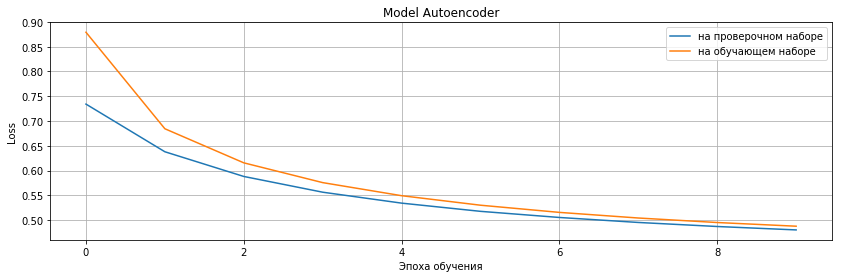

In [204]:
# Визуализируем показатели обучения
for way in history:
    show(way['loss'], 'Model ' + way['net'].name)    

### Посмотрим глазами на результаты обучения

In [205]:
# Возьмем 1 батч из тестового набора
data, _ = next(iter(validloader))

# Выход модели (автокодировщика) с этого батча
modelka = models[0]
output = modelka(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

# Посмотрим как выглядит на выходе изолированная активация каждого входного нейрона декодировщика.
# "Прогоняем единичку" по всем координитам, получаем 
# N_слоев векторов длиной в N_слоев => квадратную единичную матрицу N_слоев x N_слоев
middle_inputs = torch.eye(modelka.latent_size)
decoded = modelka.decode(middle_inputs) 
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

# кодировщик - во что превращаются данные после кодировщика
with torch.no_grad():
    encoded = modelka.E(data.view(-1, 28*28))
    enc_to_plot = ((encoded.view(-1, 1, 8, 8)+1)*0.5).clamp(0, 1).data.numpy()

# модель - если обрезать часть проводов между кодировщиком и декодировщиком
with torch.no_grad():
    encoded = modelka.E(data.view(-1, 28*28))        
    print((encoded > 0.5).sum(1)) ## что значит уровень 0.5? Ну, у сигмойды аргумент меняет знак. И ?
    encoded[encoded < 0.5] = 0. ## зачем? вариант Dropout?
    decoded_f = modelka.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 3,  5,  9, 10,  7,  8,  2,  9,  4,  3,  4,  7,  8,  5,  7,  6,  4,  9,
         4,  4,  4,  3,  6, 11,  7,  3,  7,  5,  7,  8,  3,  1,  3,  4,  5,  3,
         6,  1,  5,  8,  6,  2,  6,  5,  3,  8,  4,  7, 10,  8])


Батч из тестового набора : 


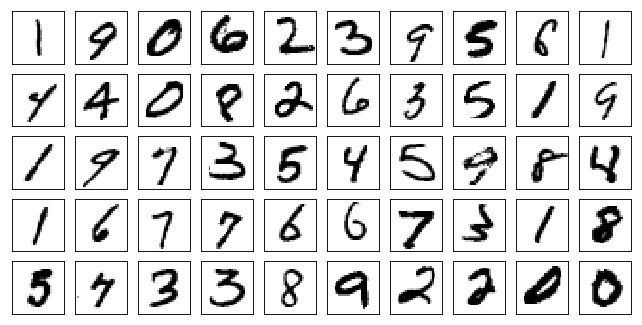

In [206]:
plot_mnist(data.data.numpy(), (5, 10), 'Батч из тестового набора')

Выход все сети автокодировщика : 


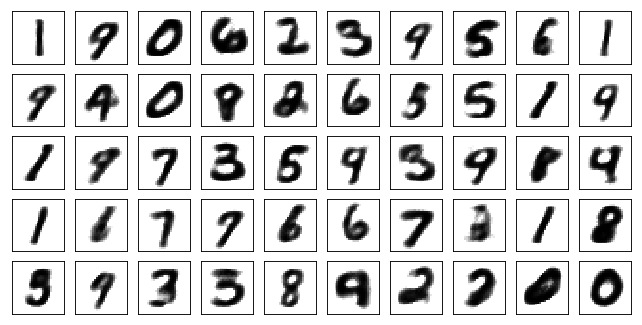

Данные в скрытом слое на выходе Кодировщика : 


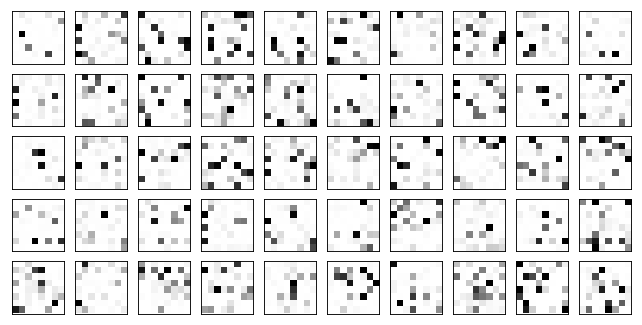

Смысл входных нейронов декодировщика : 


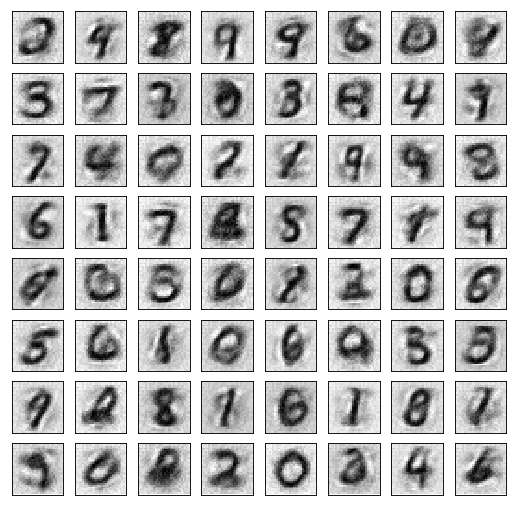

Выход сети, если потерять между код. и декод. сигналы весом < 0.5 : 


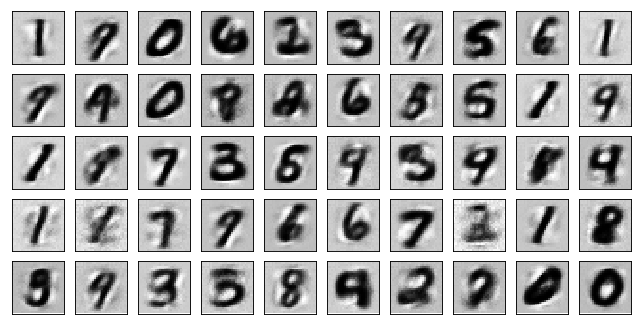

In [208]:
plot_mnist(to_plot, (5, 10), 'Выход все сети автокодировщика')
plot_mnist(enc_to_plot, (5, 10),'Данные в скрытом слое на выходе Кодировщика')
plot_mnist(dec_to_plot, (8, 8), 'Смысл входных нейронов декодировщика')
plot_mnist(f_to_plot, (5, 10),'Выход сети, если потерять между код. и декод. сигналы весом < 0.5')

### Вывод-1
Формулу дивергенции упростили, ничего не сломалось.

Цифры своеобразно разобраны на перекрывающиеся элементы в скрытом слое

### Обучение на полукартинках

In [63]:
# Hа входе массив из слоев из квадратных матриц-картинок, типичный батч
# Функция зануляет левую/правую половинку пикселей
def half_erase(matrix):    
    s_full = matrix.size()[3] #ширина картинки
    s2 = s_full // 2
    
    if np.random.normal() >= 0:
        matrix[:,:,:,0:s2] = 0
    else:
        matrix[:,:,:,s2:s_full] = 0
    
    return matrix

#### Подадим на вход наполовину забеленные картинки. Это будет выглядеть примерно так:

Пример наполовину зануленных изображений для входа : 


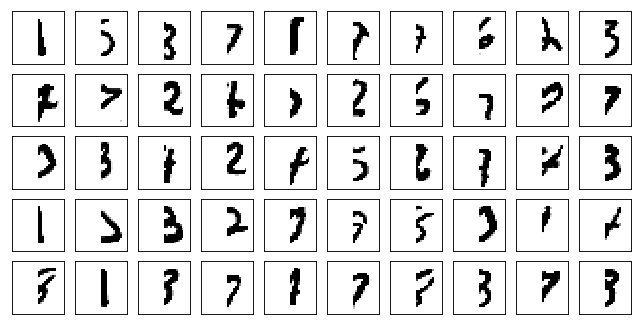

In [86]:
data, _ = next(iter(validloader))

data = half_erase(data)

to_plot = data.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (5, 10), 'Пример наполовину зануленных изображений для входа')

In [79]:
rho = 0.05 # вероятность того, что нейрон активен

model_autoencoder2 = Net(latent_size=64, name='Autoencoder2')

models2 = [model_autoencoder2]

In [70]:
# тренирует с отслеживанием показателей
# preprocessor - функция-фильтр, модифицирующая входные данные до того как их получит сеть
def train_eval(N_epoch, model, preprocessor=lambda x: x):
    print('Model %s :' % model.name)
    
    loss_history = {'train': [], 'valid': []}
    metrics_history = {'accuracy':[]}
    
    for epoch in range(1, N_epoch): # N_epoch раз прогоняем обучение-тест
        train_loss, valid_loss = [], []

        ## training part 
        model.train()
        for data, target in trainloader: # выбираем (data, target) батч за батчем
            data = preprocessor(data)  # предобработка
            
            model.optim.zero_grad()

            ## 1. forward propagation
            output = model(data)

            ## 2. loss calculation
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            
            ## 3. backward propagation
            loss.backward()

            ## 4. weight optimization
            model.optim.step()

            train_loss.append(loss.item())

        loss_history['train'].append(np.mean(train_loss))

        ## evaluation part 
        model.eval()
        for data, target in validloader:
            output = model(data)
            
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            
            valid_loss.append(loss.item())

        loss_history['valid'].append(np.mean(valid_loss))
        
        print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss), "Valid Loss: ", np.mean(valid_loss))
            
    return (model, loss_history)

In [80]:
# Запускаем обучение сети
N_epochs = 26
history2 = []
for i, model in enumerate(models2):  
      
    net, loss_history = train_eval(N_epochs,model,half_erase)
    history2.append({'net': net, 'loss': loss_history })

Model Autoencoder2 :
Epoch: 1 Training Loss:  0.7293545569603642 Valid Loss:  1.2020695224404334
Epoch: 2 Training Loss:  0.6375259739657243 Valid Loss:  1.1547738845149675
Epoch: 3 Training Loss:  0.5851386257136861 Valid Loss:  1.113625174264113
Epoch: 4 Training Loss:  0.5489819718835255 Valid Loss:  1.0782282243172328
Epoch: 5 Training Loss:  0.5244894791704913 Valid Loss:  1.0473686220745246
Epoch: 6 Training Loss:  0.5078835307620466 Valid Loss:  1.0268049207826455
Epoch: 7 Training Loss:  0.49408980005731185 Valid Loss:  1.010924433916807
Epoch: 8 Training Loss:  0.48454354604085287 Valid Loss:  1.000855557868878
Epoch: 9 Training Loss:  0.47703749664748707 Valid Loss:  0.9906333545843761
Epoch: 10 Training Loss:  0.46986236283555627 Valid Loss:  0.982856081922849
Epoch: 11 Training Loss:  0.4654413644845287 Valid Loss:  0.9795762720207374
Epoch: 12 Training Loss:  0.4599454081927737 Valid Loss:  0.9747841060161591
Epoch: 13 Training Loss:  0.45752960089594125 Valid Loss:  0.971

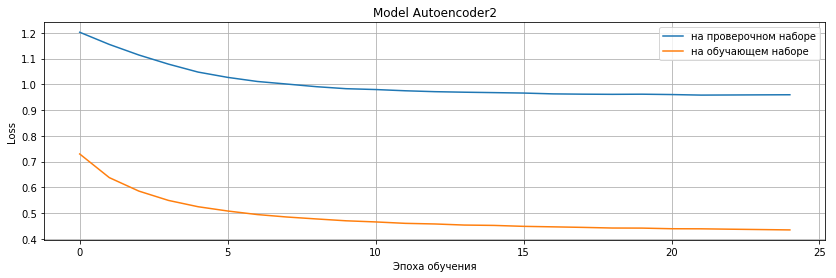

In [81]:
# Визуализируем показатели обучения
for way in history2:
    show(way['loss'], 'Model ' + way['net'].name)    

### Снова посмотрим глазами на результаты обучения

In [82]:
# Возьмем 1 батч из тестового набора
data, _ = next(iter(validloader))

# Выход модели (автокодировщика) с этого батча
modelka = models2[0]
output = modelka(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

# Посмотрим как выглядит на выходе изолированная активация каждого входного нейрона декодировщика.
# "Прогоняем единичку" по всем координитам, получаем 
# N_слоев векторов длиной в N_слоев => квадратную единичную матрицу N_слоев x N_слоев
middle_inputs = torch.eye(modelka.latent_size)
decoded = modelka.decode(middle_inputs) 
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

# кодировщик - во что превращаются данные после кодировщика
with torch.no_grad():
    encoded = modelka.E(data.view(-1, 28*28))
    enc_to_plot = ((encoded.view(-1, 1, 8, 8)+1)*0.5).clamp(0, 1).data.numpy()

# модель - если обрезать часть проводов между кодировщиком и декодировщиком
with torch.no_grad():
    encoded = modelka.E(data.view(-1, 28*28))        
    print((encoded > 0.5).sum(1)) ## что значит уровень 0.5? Ну, у сигмойды аргумент меняет знак. И ?
    encoded[encoded < 0.5] = 0. ## зачем? вариант Dropout?
    decoded_f = modelka.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 3,
        0, 0])


Батч из тестового набора : 


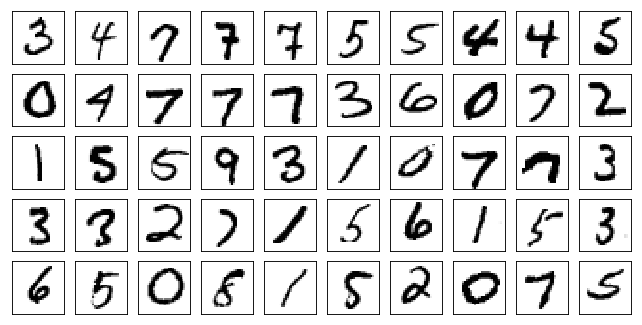

In [83]:
plot_mnist(data.data.numpy(), (5, 10), 'Батч из тестового набора')

Выход все сети автокодировщика : 


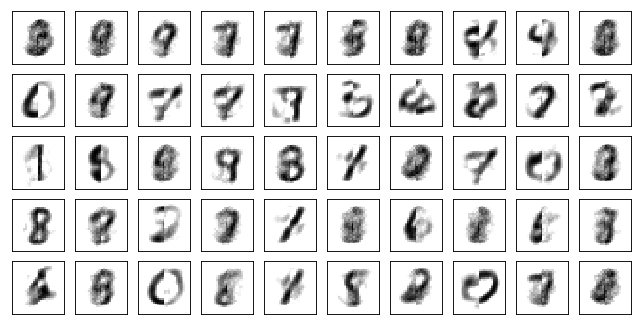

Данные в скрытом слое на выходе Кодировщика : 


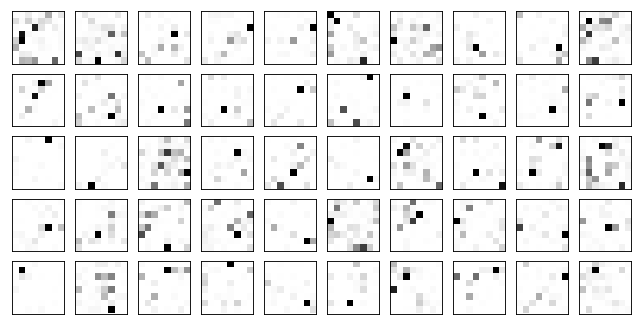

Смысл входных нейронов декодировщика : 


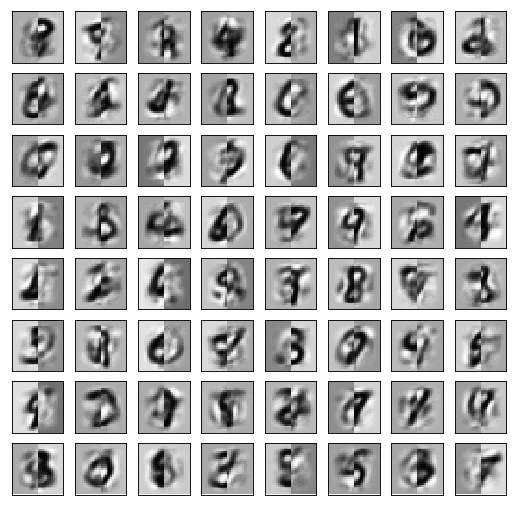

Выход сети, если потерять между код. и декод. сигналы весом < 0.5 : 


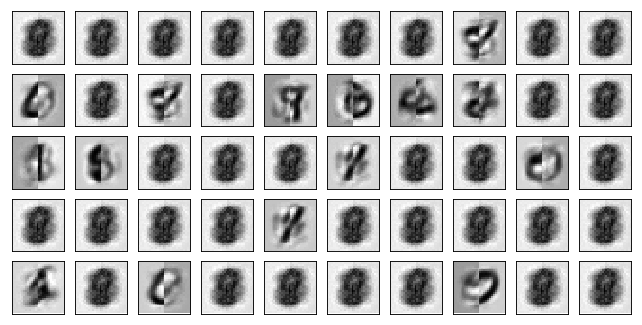

In [84]:
plot_mnist(to_plot, (5, 10), 'Выход все сети автокодировщика')
plot_mnist(enc_to_plot, (5, 10),'Данные в скрытом слое на выходе Кодировщика')
plot_mnist(dec_to_plot, (8, 8), 'Смысл входных нейронов декодировщика')
plot_mnist(f_to_plot, (5, 10),'Выход сети, если потерять между код. и декод. сигналы весом < 0.5')

### Вывод-2
Даже при такой грубой порче входных данных некоторые цифры (особенно симметричные) угадываются.
Линия симметрии также видна на выхода декодировщика с one-hot активацмей.

Архитектура, даже такая простая, обладает большим запасом прочности. Хотя, как видно, и не безграничным.